In [1]:
import torch
import sklearn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [2]:
train_data = datasets.FashionMNIST(
    root="FashionMNIST",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="FashionMNIST",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [3]:
 len(train_data), len(test_data)

(60000, 10000)

In [42]:
image, label = train_data[0]
label, image
test_data[1][1]

2

In [5]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [7]:
image.shape, label

(torch.Size([1, 28, 28]), 9)

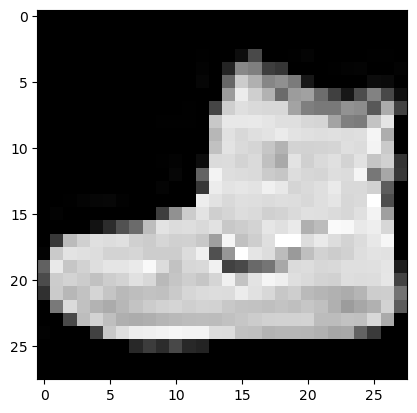

In [8]:
import matplotlib.pyplot as plt

image, label = train_data[0]

plt.imshow(image.squeeze(), cmap="gray")

In [9]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: FashionMNIST
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: FashionMNIST
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [10]:
from torch.utils.data import DataLoader

BTACH_SIZE = 32

train_data_loader = DataLoader(dataset=train_data, batch_size=BTACH_SIZE, shuffle=True)

test_data_loader = DataLoader(dataset=test_data, batch_size=BTACH_SIZE, shuffle=False)

In [11]:
# Build a model
import torch
from torch import nn
import numpy as np


flatten_model = nn.Flatten()

torch.manual_seed(40)
# Tiny VVG model
class FashionMNISTModelV2(nn.Module):
    
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3,
                      stride=1,
                      padding=1 # same padding value
                     ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units, 
                      kernel_size=3,
                      stride=1,
                      padding=1 # same padding value
                     ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # 27
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units, 
                      kernel_size=3,
                      stride=1,
                      padding=1 # same padding value
                     ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units, 
                      kernel_size=3,
                      stride=1,
                      padding=1 # same padding value
                     ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # 26
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape),
        )
        
    def forward(self, x):
        x  = self.conv_block_1(x)
        # print(f"Output shape of conv_block_1: {x.shape}")
        x = self.conv_block_2(x)
        # print(f"Output shape of conv_block_2: {x.shape}")
        x = self.classifier(x) 
        # print(f"Output shape of conv_block_3: {x.shape}")
        return x
    
    
def normalizePredictions(y_pred):
    vals = torch.softmax(y_pred, dim=1)
    return torch.argmax(vals, dim=1)

In [12]:
model_0 = FashionMNISTModelV2(
          input_shape=1,
          hidden_units=10,
          output_shape=10,
          )

dynmmy_img = torch.rand([10, 1, 28, 28])

test_conv = nn.Conv2d(in_channels=1, 
                      out_channels=10, 
                      kernel_size=3,
                      stride=1,
                      padding=1
                     )

restlt = test_conv(dynmmy_img)
 
model_result = model_0(dynmmy_img)

restlt.shape, model_result.shape, image.shape

(torch.Size([10, 10, 28, 28]), torch.Size([10, 10]), torch.Size([1, 28, 28]))

In [13]:
model_0.eval()
dynmmy_x = torch.rand([10, 1, 28, 28]) # 1 -> one image data, 1 -> no of color channel, 28, 28 -> image matrix

with torch.inference_mode():
    y_pred = model_0(dynmmy_x)
    y_pred_normalized = normalizePredictions(y_pred)

y_pred_normalized

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [14]:
# Loss and optimizer
loss_fn = nn.CrossEntropyLoss() # is combines BCE with sigmoid

optimizer = torch.optim.SGD(params = model_0.parameters(), lr=0.1)

In [15]:
from helpers import calculate_accuracy

torch.manual_seed(42)

epochs = 3

train_epochs = []
train_loss_arr = []
test_loss_arr = []

for epoch in range(epochs):
    
    train_loss = 0;
    train_acc = 0;
    
    print(f"Epoch: {epoch}\n----------")
    
    train_epochs.append(epoch)
    
    for batch, (X, Y) in enumerate(train_data_loader):
        
        model_0.train();
        
        y_logits_train = model_0(X)
        
        loss = loss_fn(y_logits_train, Y)
        
        y_pred_train = normalizePredictions(y_logits_train)
        
        train_loss+=loss
        
        train_acc+=calculate_accuracy(Y ,y_pred_train)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        model_0.eval()
        
        # if batch % 400 == 0:
            # print(f"batch : {batch}")
            
    # Average train_loss        
    train_loss /= len(train_data_loader)
    train_acc /= len(train_data_loader)
    
    train_loss_arr.append(train_loss.item())
    
    print(f"Train loss for {epoch}: {train_loss} | Train acc: {train_acc}")
    
    ### Testing
    
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for X_test, Y_test in test_data_loader:
            
            y_logits_test = model_0(X_test)
        
            test_loss = loss_fn(y_logits_test, Y_test)
            
            test_loss+=test_loss
            
            y_pred_test = normalizePredictions(y_logits_test)
            
            test_acc+=calculate_accuracy(Y_test ,y_pred_test)
            
        test_loss/=len(test_data_loader)
        test_acc/=len(test_data_loader)
        
        test_loss_arr.append(test_loss.item())
        
        print(f"Test loss for {epoch}: {test_loss}, Test acc: {test_acc}")
    
    

Epoch: 0
----------
Train loss for 0: 0.5913727283477783 | Train acc: 78.69666666666667
Test loss for 0: 0.0020983191207051277, Test acc: 85.80271565495208
Epoch: 1
----------
Train loss for 1: 0.3487224280834198 | Train acc: 87.505
Test loss for 1: 0.002139457268640399, Test acc: 87.80950479233226
Epoch: 2
----------
Train loss for 2: 0.3061031103134155 | Train acc: 89.02
Test loss for 2: 0.0014060168759897351, Test acc: 88.88777955271566


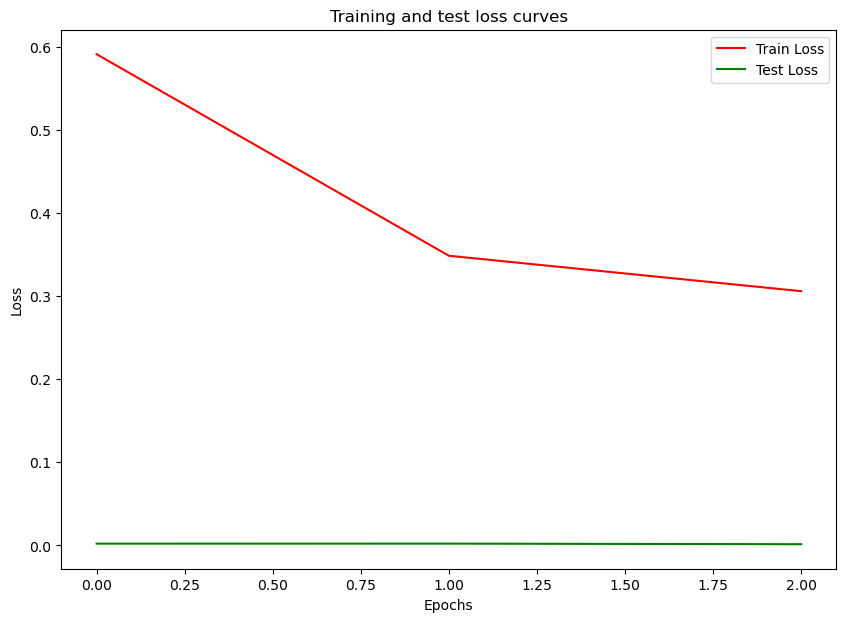

In [17]:
from helpers import plot_train_graph, plot_decision_boundary

plot_train_graph(x=train_epochs, y_train=train_loss_arr, y_test=test_loss_arr)

In [18]:
def make_prediction( model, data):
    pred_probs = [];
    model.eval()
    
    with torch.inference_mode():
        for sample in data:
            
            sample = torch.unsqueeze(sample, dim=0)
            
            pred_logits = model(sample)
            
            y_pred_train = normalizePredictions(pred_logits)
            
            pred_probs.append(y_pred_train)
            
    return torch.stack(pred_probs)


In [47]:
import random
torch.manual_seed(0)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample);
    test_labels.append(label);
    
test_labels
sample[0].shape
test_labels

[6, 0, 9, 6, 7, 2, 3, 8, 1]

In [48]:
pred_labels = make_prediction(model_0, test_samples)

Text(0.5, 1.0, 'Shirt | Shirt')

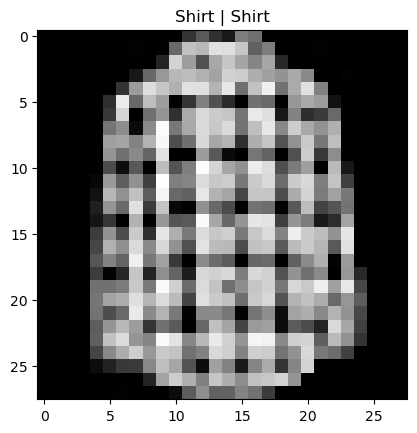

In [49]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]]+" | " + class_names[pred_labels[0]])


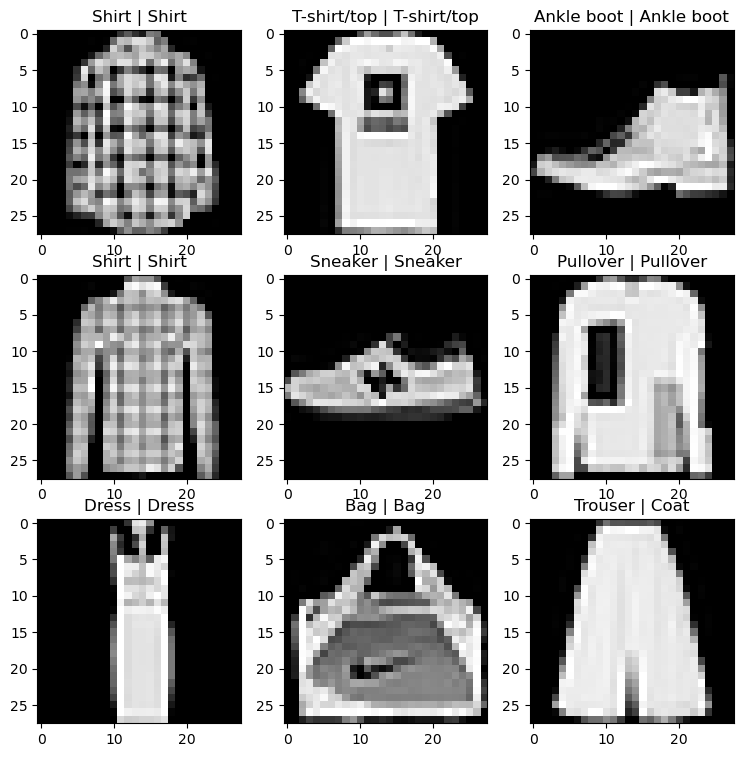

In [50]:
plt.figure(figsize=(9,9))
nrows=3
ncols=3

for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.squeeze(), cmap="gray")
    plt.title(class_names[test_labels[i]]+" | " + class_names[pred_labels[i]])
    